# Úkol č. 1 - redukce dimenzionality a binární klasifikace

  * **Deadline je 22. 4. 2024, 23:59:59**, pokud odevzdáte úkol do 29. 4. 2024, 23:59:59, budete penalizování -12 body, pozdější odevzdání je bez bodu.
  * V rámci tohoto úkolu se musíte vypořádat s vysokou dimenzí problému a poté úspěšně aplikovat vhodný klasfikační model.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budou strhávány body.

## Zdroj dat

 * Zdrojem dat jsou soubory `train.csv` a `evaluate.csv`.
 * Jedná se o obrázky 28x28 pixelů ve stupních šedi, které byly získány z [Fashion Mnist datasetu](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
 * Soubor `train.csv` obsahuje trénovací data.
 * Cílová (vysvětlovaná) proměnná se jmenuje **label**.
 * Soubor `evaluate.csv` obsahuje testovací data bez hodnot skutečných labelů.

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **25 bodů**:
  * V notebooku načtěte data ze souboru `train.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování, porovnávání modelů a následnou predikci výkonnosti finálního modelu.
  * Proveďte základní průzkum dat a svá pozorování diskutujte. Některé obrázky také zobrazte.
  * Postupně aplikujte modely **SVM**, **naivní Bayesův klasifikátor** a **LDA**, přičemž pro každý z nich:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Vyberte si hlavní hyperparametry k ladění (pokud model má hyperparametry) a najděte jejich nejlepší hodnoty.
      * Experimentujte se standardizací/normalizací dat.
      * U SVM vyzkoušejte alespoň dvě různé jádrové funkce.
      * Získané výsledky vždy řádně okomentujte.


  * Postupně aplikujte metody redukce dimenzionality PCA a LLE, přičemž pro každou z nich: 
      * Zopakujte předchozí kroky a pokuste modely vylepšit
      * Zkoumejte jaká dimenze je z hlediska výkonnosti finálního modelu nejlepší.
      * Získané výsledky vždy řádně okomentujte.
    
  * Ze všech zkoušených možností vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici.
  
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluate.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do sloupce **label** a identifikátory do sloupce **ID**. Tento soubor též odevzdejte (uložte do projektu vedle notebooku).
   
   * Ukázka prvních řádků souboru `results.csv`:
  
```
ID,label
0,0
1,1
...
```

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html.
  * Vytvořte i csv soubor `results.csv` s predikcemi a uložte ho v rámci projektu vedle ipython notebooku.

In [104]:
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import pickle

import random

import matplotlib.pyplot as plt

random_seed = 42

# Data Exploration

First of all, lets become acquainted with our data and explore it a little bit:

In [2]:
df_data = pd.read_csv('train.csv')

Split our data into labels and images, and into train, validation datasets and prepare cross validation datasets.

In [4]:
def split_data(data):
    print(f'Data shape: {data.shape}')
    labels = data['label']
    images = data.drop('label', axis=1)
    print(f'Images data shape: {images.shape}')
    X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.4, random_state=random_seed)
    print(f"Train shape: {X_train.shape}")
    print(f"Validation shape: {X_val.shape}")
    return X_train, X_val, y_train, y_val


X_train, X_val, y_train, y_val = split_data(df_data)
# also prepare dataset for cross validation
X_cross_val = pd.concat((X_train, X_val))
y_cross_val = pd.concat((y_train, y_val))

Data shape: (2400, 785)
Images data shape: (2400, 784)
Train shape: (1440, 784)
Validation shape: (960, 784)


We have dataset with images - first column is a label, the rest are pixels. The dimension is high - 784 pixels/features. 
Lets see the tabular data. For convenience, we will split show only random n columns, that should be enough to grasp how data looks in a table.

In [67]:
n = 5
np.random.seed(random_seed)
data_train = pd.concat((y_train, X_train), axis=1)
random_indices = np.random.choice(range(1, data_train.shape[1]), size=n, replace=False)
selected_columns = data_train.head().iloc[:, selected_indices]
display(selected_columns)

,label,pixel598,pixel590,pixel209,pixel292,pixel175
1862,1,223,0,175,200,0
2261,0,0,0,173,136,0
607,0,53,0,143,138,0
415,1,230,0,224,228,232
273,0,0,0,226,226,0


In **label** column:
- $0$ value represents Trousers class
- $1$ value represents Dress class

Lets show some images with histograms of pixels distribution:

In [21]:
def draw_images(images, y, shape, scale=1, rd_seed=None):
    max_images = 2 * shape[0] * shape[1]
    images_sample = images.sample(n=max_images, random_state=rd_seed)
    labels_sample = y[images_sample.index]

    labels = labels_sample.to_numpy()
    images = images_sample.to_numpy()

    fig = plt.figure(figsize=(scale * 2 * shape[1], scale * 2 * shape[0]), constrained_layout=True)
    i = 0
    while i < max_images and i < images.shape[0]:
        ax_hist = fig.add_subplot(2 * shape[0], 2 * shape[1], i + 1)
        ax_hist.hist(images[i], bins=256)
        ax_hist.set_yscale('log')
        ax_hist.set_ylabel("Count (log scale)")
        ax_hist.set_xlabel("Pixel value")

        ax_image = fig.add_subplot(2 * shape[0], 2 * shape[1], i + 2, xticks=[], yticks=[])
        image = images[i].reshape((28, 28))
        ax_image.imshow(image, cmap="Oranges", interpolation="nearest")
        ax_image.set_title(f"Trousers\n(Y = {labels[i]})" if labels[i] == 0 else f"Dress\n(Y = {labels[i]})")

        i += 2

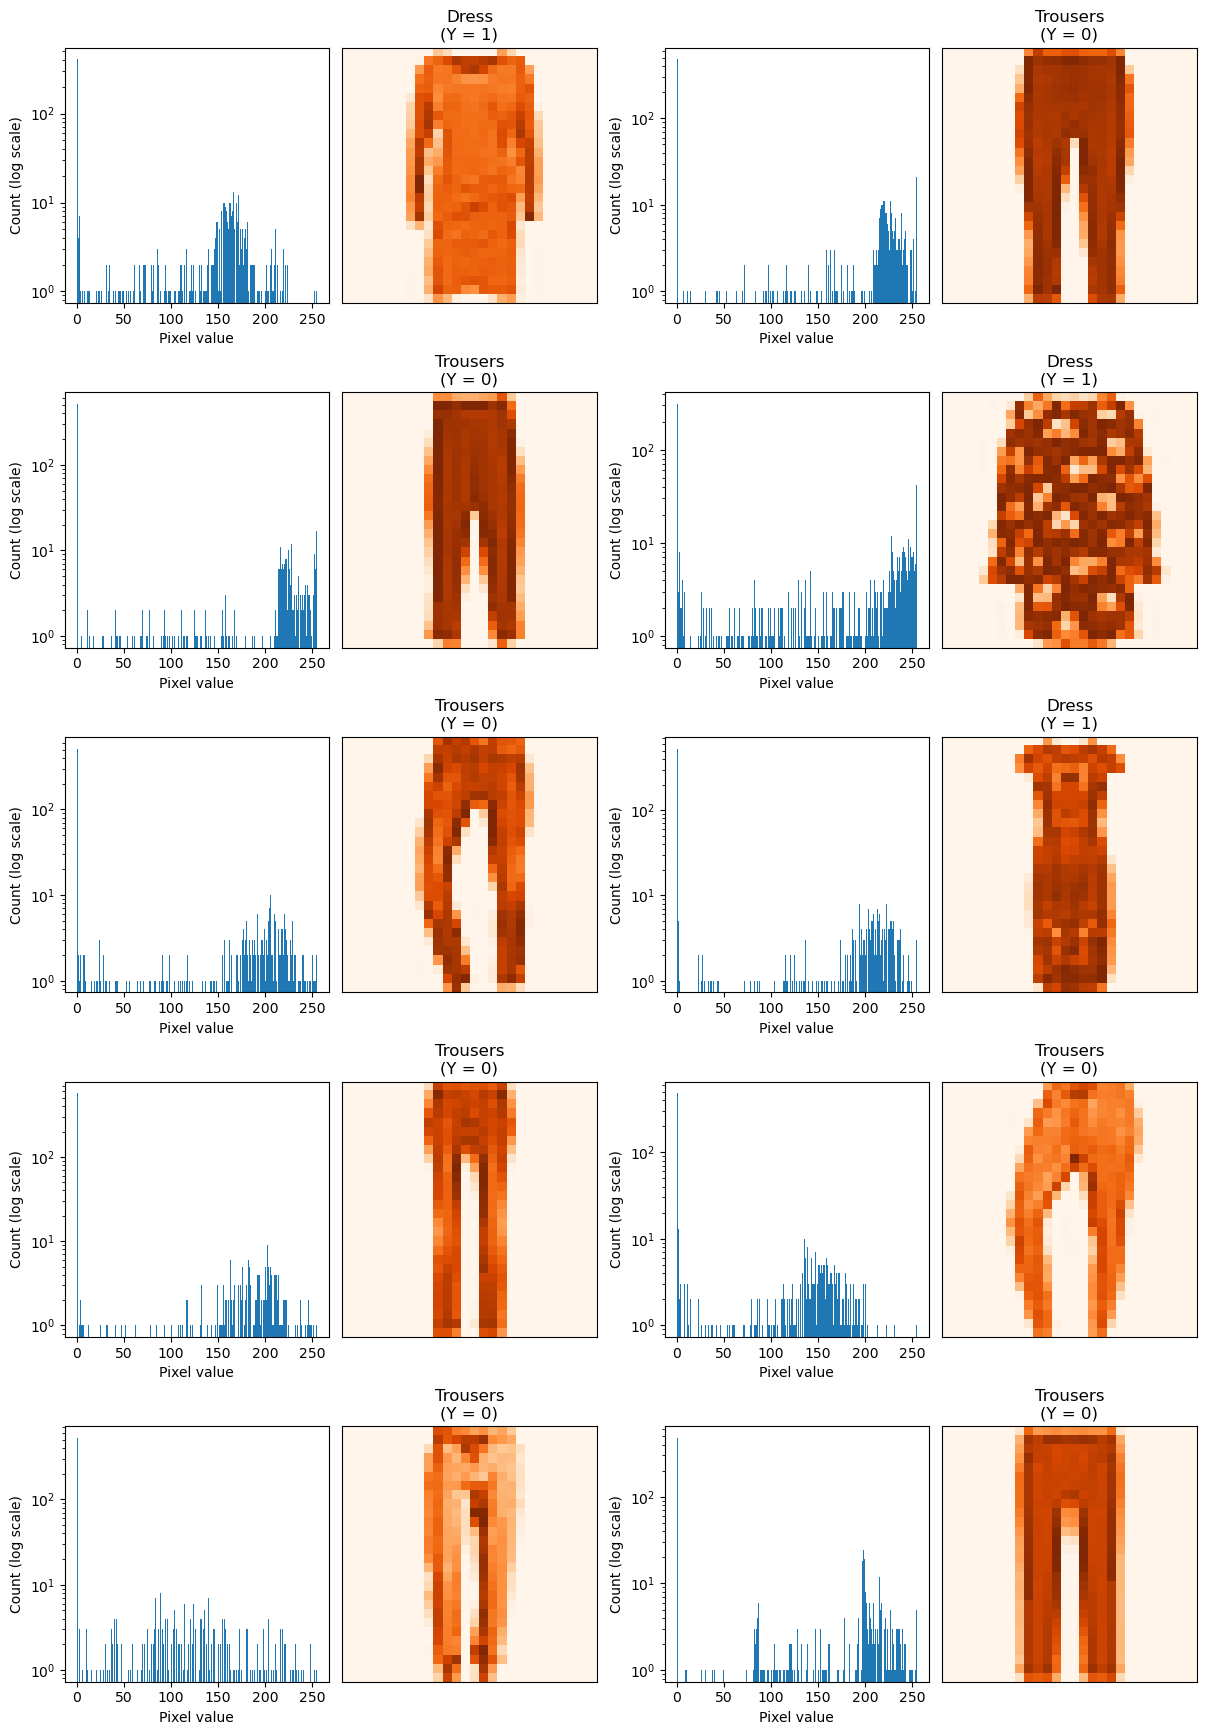

In [22]:
draw_images(images=X_train, y=y_train, scale=3, shape=(5, 2), rd_seed=random_seed)

Also we can look at some specific image for more analysis.

In [28]:
def inspect_image(image, label=None, index=None, suptitle=None):
    if isinstance(image, pd.DataFrame):
        image = pd.Series(image.iloc[0])
    display(image.describe())
    image_arr = image.to_numpy()
    image = image_arr.reshape((28, 28))

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 4), constrained_layout=True)
    pos = ax1.imshow(image, cmap="Oranges", interpolation="nearest")
    ax1.set_xticks([])
    ax1.set_yticks([])
    if label:
        title = f"{'Trousers' if label == 0 else 'Dress'}"
        if index:
            title += "\n" + f"{index}"
        ax1.set_title(title)
    else:
        ax1.set_title("Image")
    fig.colorbar(mappable=pos)

    ax2.hist(image_arr, bins=256)
    ax2.set_yscale('log')
    ax2.set_title("Image histogram")
    ax2.set_ylabel("Count (log scale)")
    ax2.set_xlabel("Pixel value")

    if suptitle:
        fig.suptitle(suptitle)



Now we will pick random image and look at it:

count    784.000000
mean      68.954082
std       80.621709
min        0.000000
25%        0.000000
50%        0.000000
75%      158.250000
max      255.000000
Name: 1669, dtype: float64

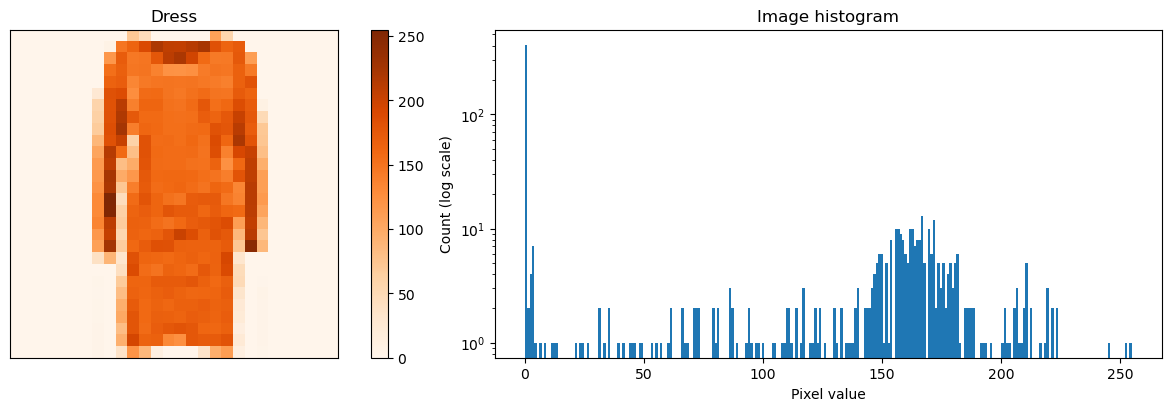

In [29]:
sample_image = X_train.sample(1, random_state=random_seed)
sample_label = y_train[sample_image.index].item()

inspect_image(sample_image, sample_label)

We can see now some more interesting statistics:
- mean pixel value
- min and max pixel value - as expected, it is $0$ and $255$.

In histogram we can see how pixels are distributed. It uses log scale, so the number of pixels with $0$ value is quite high.

For the sake of curiosity, lets inspect mean image across each classe and across both classes.

count    784.000000
mean      61.181063
std       70.673427
min        0.000000
25%        0.652778
50%       18.737847
75%      135.243924
max      187.043056
dtype: float64

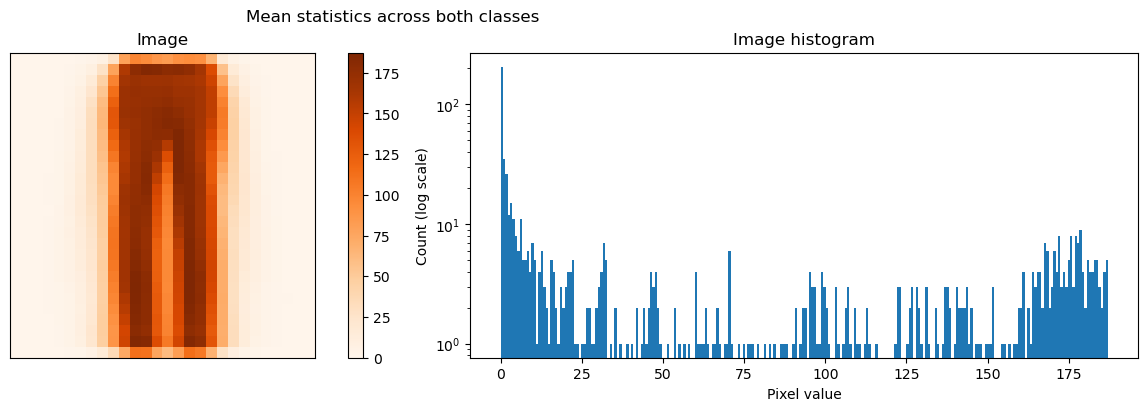

In [31]:
mean_image = pd.Series(X_train.mean(axis=0))
inspect_image(mean_image, suptitle="Mean statistics across both classes")

Mean image across both classes more resembles the Trousers class, than the Dress class. Lets see how both classes rate to each other.

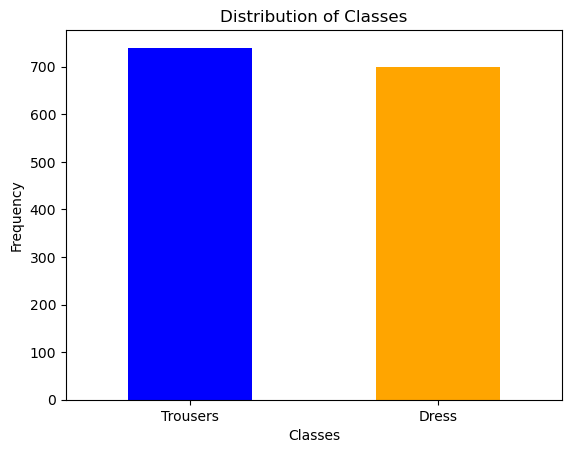

In [12]:
fig, ax = plt.subplots()
class_counts = y_train.value_counts()
g = class_counts.plot(ax=ax, kind='bar', color=['blue', 'orange'])
ax.set_title("Distribution of Classes")
ax.set_xlabel("Classes")
ax.set_ylabel("Frequency")
ax.set_xticks(class_counts.index, labels=['Trousers', 'Dress'], rotation=0)
plt.show()

We see, that Trousers and Dress classes are quite aligned, with little inclination to Trousers.

Now lets see mean image across all Trousers class samples and all Dress class samples:

count    784.000000
mean      56.563679
std       74.190149
min        0.000000
25%        0.620946
50%        6.450000
75%      120.630405
max      207.806757
dtype: float64

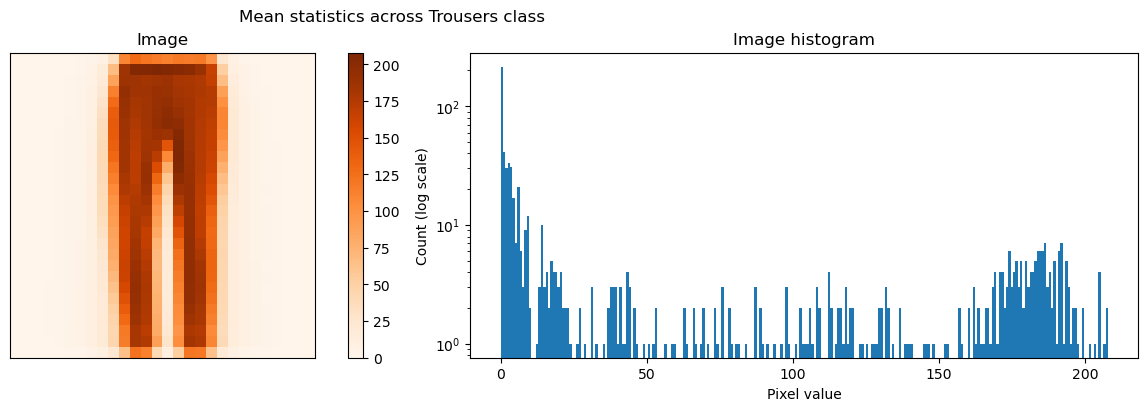

In [13]:
df_trousers = X_train[y_train == 0]
df_trousers_mean = pd.Series(df_trousers.mean(axis=0))
inspect_image(df_trousers_mean, suptitle="Mean statistics across Trousers class")

count    784.000000
mean      66.062298
std       71.472201
min        0.000000
25%        0.598571
50%       29.988571
75%      150.740357
max      189.927143
dtype: float64

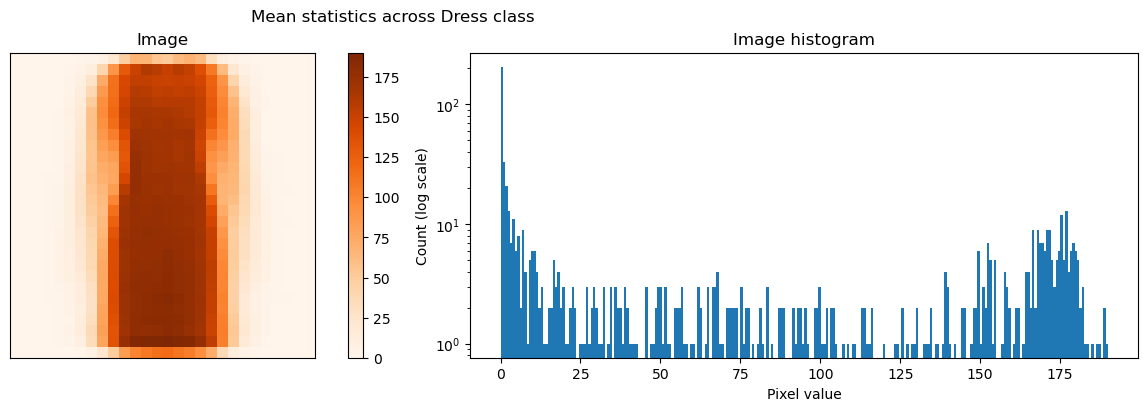

In [32]:
df_dresses = X_train[y_train == 1]
df_dresses_mean = pd.Series(df_dresses.mean(axis=0))
inspect_image(df_dresses_mean, suptitle="Mean statistics across Dress class")

Muzeme si vsimnout, ze usporadanim pixelu na obrazcich umime hned rozpoznat, jestli to jsou saty nebo panty ve stredni hodnote. Ale pokud se podivame na histogram, tak ten rozdil skoro nevidime. Tedy klicovou vlasntnost hraje nejspije rozpolezeni pixelu v prostoru obrazku, nikoliv jejich magnituda. 
Notice, that classes can be easily differentiated by pixels positions, when in the same time their histograms look almost identically. This may imply, that 

# Classification Without Dimensionality Reduction

Nejprve zkusime natrenovat modely na datech bez redukce dimenzionality. Muze nam to dat docela dobrou baselinu pro porovnani kdyz budeme data redukovat. Predem lze rict, ze redukce tady by mela hodne pomoct, protoze nektere dimenze (pixely) jsou nulove napric vsemi obrazky.

## SVM

Prvnim modelem bude Support Vector Machine. 

SVM hyperparameters to fine tune:
- C - regularization hyperparameter 
    - spocitej pro nu 0.1, 0.5, 0.01 - jako reference hodnot pro dataset velky 1440 bodu   
- kernel - linear, poly, rbf, sigmoid TODO vypis funkce
- gamma - spocitej hodnoty scale a auto, a kolem nich vybirej prostor hyperparametru

In [54]:
# global parameters for train function
training_verbosity = 10
cross_validation_folds = 5
n_jobs = 10


def train(X, y, model, param_grid, file_name, use_existing=True):
    if use_existing:
        try:
            with open(file_name, 'rb') as file:
                grid_search = pickle.load(file)
            return grid_search
        except FileNotFoundError:
            print("Could not open file {} (file not found error), proceeding with training.".format(file_name))

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy',
                               cv=cross_validation_folds, n_jobs=n_jobs,
                               verbose=training_verbosity, return_train_score=True)
    grid_search.fit(X=X, y=y)
    with open(file_name, 'wb') as file:
        pickle.dump(grid_search, file=file)

    return grid_search

In [52]:
def evaluate(grid_search, title):
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score:", grid_search.best_score_)

    mean_train_accuracies = grid_search.cv_results_['mean_train_score']
    mean_val_accuracies = grid_search.cv_results_['mean_test_score']

    fig, ax = plt.subplots(figsize=(20, 7))

    ax.plot(mean_train_accuracies, 'o-', label='train', color='red')
    ax.plot(mean_val_accuracies, 'o-', label='validation', color='navy')
    ax.set_title(title)
    ax.set_xlabel('hyperparameter index')
    ax.set_ylabel('mean accuracy')
    ax.legend(loc="lower right")

We will conduct training with original data, normalized data and scaled data. Because training is a slow process, we will train by kernel hyperparameter separately, but for each considering original data, normalization and standardization. Also kernel parameter appears to be the most important, and also we will see better evaluation graphs.

In [64]:
C = np.linspace(start=1e-9, stop=1e3, num=100)

param_grid_linear = {
    'kernel': ['linear'],
    'C': C
}

param_grid_poly = {
    'kernel': ['poly'],
    'degree': range(2, 4),
    'gamma': ['scale', 'auto'],
    'C': C
}

param_grid_rbf = {
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto'],
    'C': C
}

param_grid = [param_grid_linear, param_grid_poly, param_grid_rbf]

model = SVC(random_state=random_seed)

#### Original Data

In [ ]:
grid_search = train(X_cross_val, y_cross_val, model, param_grid=param_grid,
                    file_name=f"train_results/svc/original_rd-{random_seed}.pickle")

Best parameters: {'C': 20.202020203, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Best cross-validation score: 0.98125


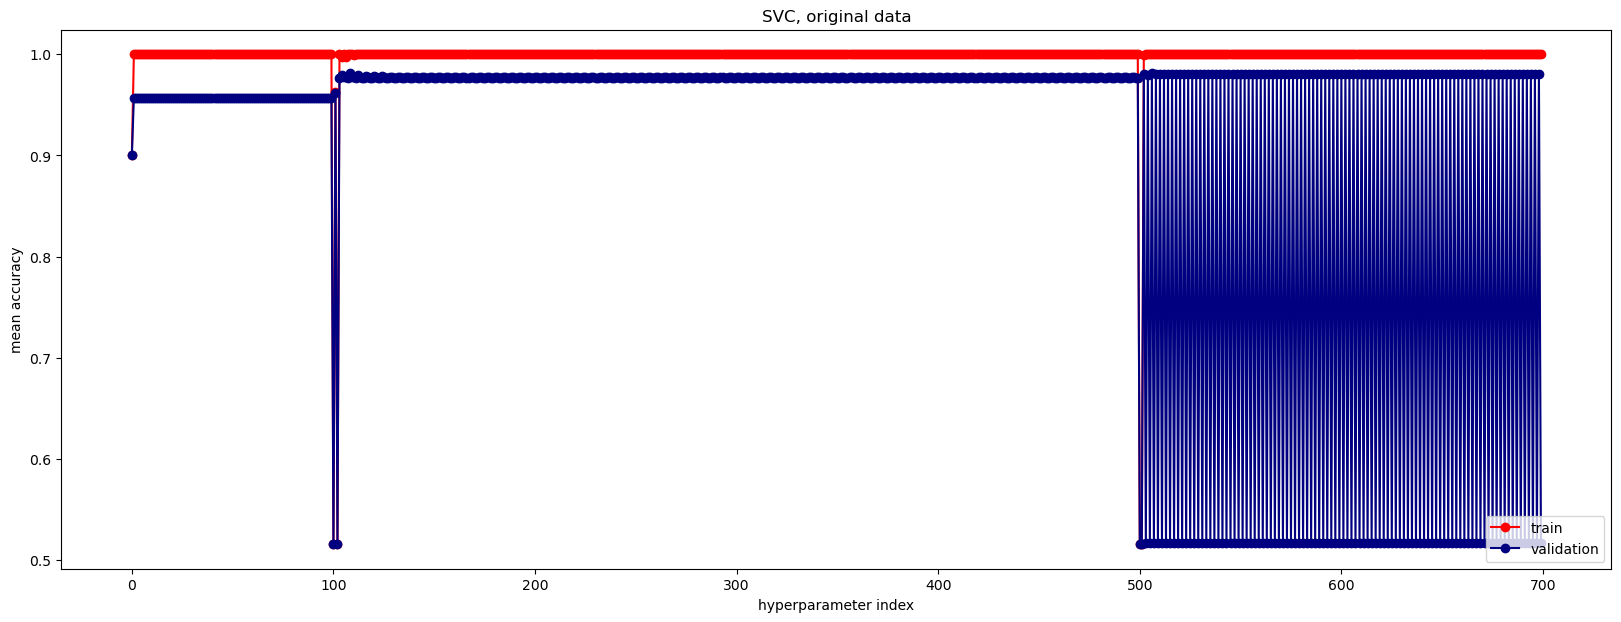

In [69]:
evaluate(grid_search, title="SVC, original data")

On the plot we is possible to distinguish, when the kernel was changes by the sudden drop of accuracy. First the most left part is linear, after that follows polynomial and rbf afterwards.
The best model has cross validation score 0.98125.

#### Normalization

Normalization and standardization can be beneficial, when machine learning model works with distances. But though SVM works with distances under the hood, our data have the same scaling. But for the sake of curiousity, lets try normalization and then standardization

In [57]:
scaler = MinMaxScaler()
X_cross_val_normalized = scaler.fit_transform(X_cross_val)

In [70]:
grid_search = train(X_cross_val_normalized, y_cross_val, model, param_grid=param_grid,
                    file_name=f"train_results/svc/normalization_rd-{random_seed}.pickle")

Could not open file train_results/svc/normalization_rd-42.pickle (file not found error), proceeding with training.
Fitting 5 folds for each of 700 candidates, totalling 3500 fits
[CV 4/5; 2/700] START C=10.101010102, kernel=linear.............................
[CV 4/5; 2/700] END C=10.101010102, kernel=linear;, score=(train=1.000, test=0.960) total time=   0.8s
[CV 3/5; 3/700] START C=20.202020203, kernel=linear.............................
[CV 3/5; 3/700] END C=20.202020203, kernel=linear;, score=(train=1.000, test=0.975) total time=   1.0s
[CV 3/5; 4/700] START C=30.303030304, kernel=linear.............................
[CV 3/5; 4/700] END C=30.303030304, kernel=linear;, score=(train=1.000, test=0.975) total time=   0.6s
[CV 2/5; 5/700] START C=40.404040404999996, kernel=linear.......................
[CV 2/5; 5/700] END C=40.404040404999996, kernel=linear;, score=(train=1.000, test=0.940) total time=   0.6s
[CV 2/5; 6/700] START C=50.505050505999996, kernel=linear......................

Best parameters: {'C': 20.202020203, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Best cross-validation score: 0.9820833333333333


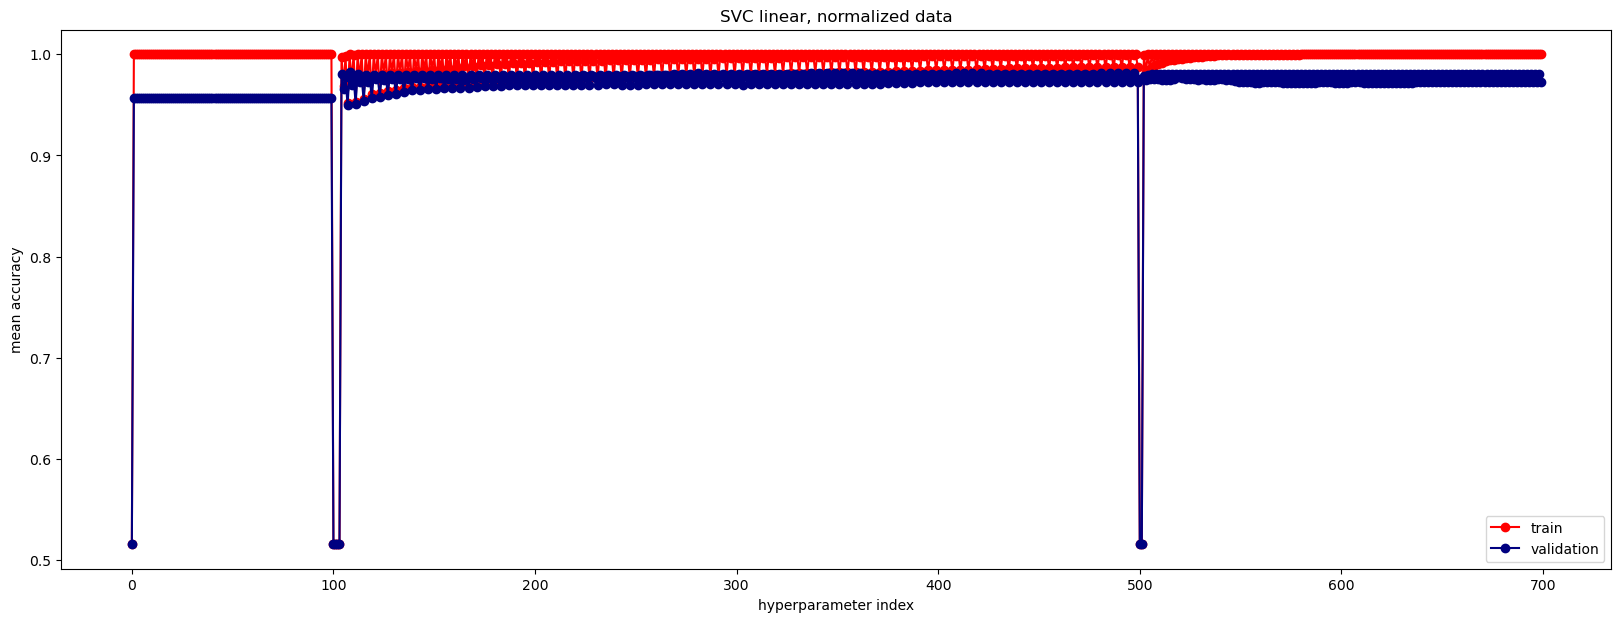

In [71]:
evaluate(grid_search, title="SVC linear, normalized data")

As we can see, normalization didn't help, lets try standardization:

In [73]:
scaler = StandardScaler()
X_cross_val_standardized = scaler.fit_transform(X_cross_val)

In [74]:
grid_search = train(X_cross_val_standardized, y_cross_val, model, param_grid=param_grid,
                    file_name=f"train_results/svc/standardization_rd-{random_seed}.pickle")

Could not open file train_results/svc/standardization_rd-42.pickle (file not found error), proceeding with training.
Fitting 5 folds for each of 700 candidates, totalling 3500 fits
[CV 4/5; 635/700] END C=676.767676768, gamma=scale, kernel=rbf;, score=(train=1.000, test=0.975) total time=   0.7s
[CV 2/5; 637/700] START C=686.8686868689999, gamma=scale, kernel=rbf............
[CV 2/5; 637/700] END C=686.8686868689999, gamma=scale, kernel=rbf;, score=(train=1.000, test=0.975) total time=   0.8s
[CV 2/5; 639/700] START C=696.96969697, gamma=scale, kernel=rbf.................
[CV 2/5; 639/700] END C=696.96969697, gamma=scale, kernel=rbf;, score=(train=1.000, test=0.975) total time=   0.7s
[CV 1/5; 641/700] START C=707.070707071, gamma=scale, kernel=rbf................
[CV 1/5; 641/700] END C=707.070707071, gamma=scale, kernel=rbf;, score=(train=1.000, test=0.985) total time=   0.8s
[CV 1/5; 643/700] START C=717.171717172, gamma=scale, kernel=rbf................
[CV 1/5; 643/700] END C=717.

Best parameters: {'C': 20.202020203, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
Best cross-validation score: 0.9808333333333333


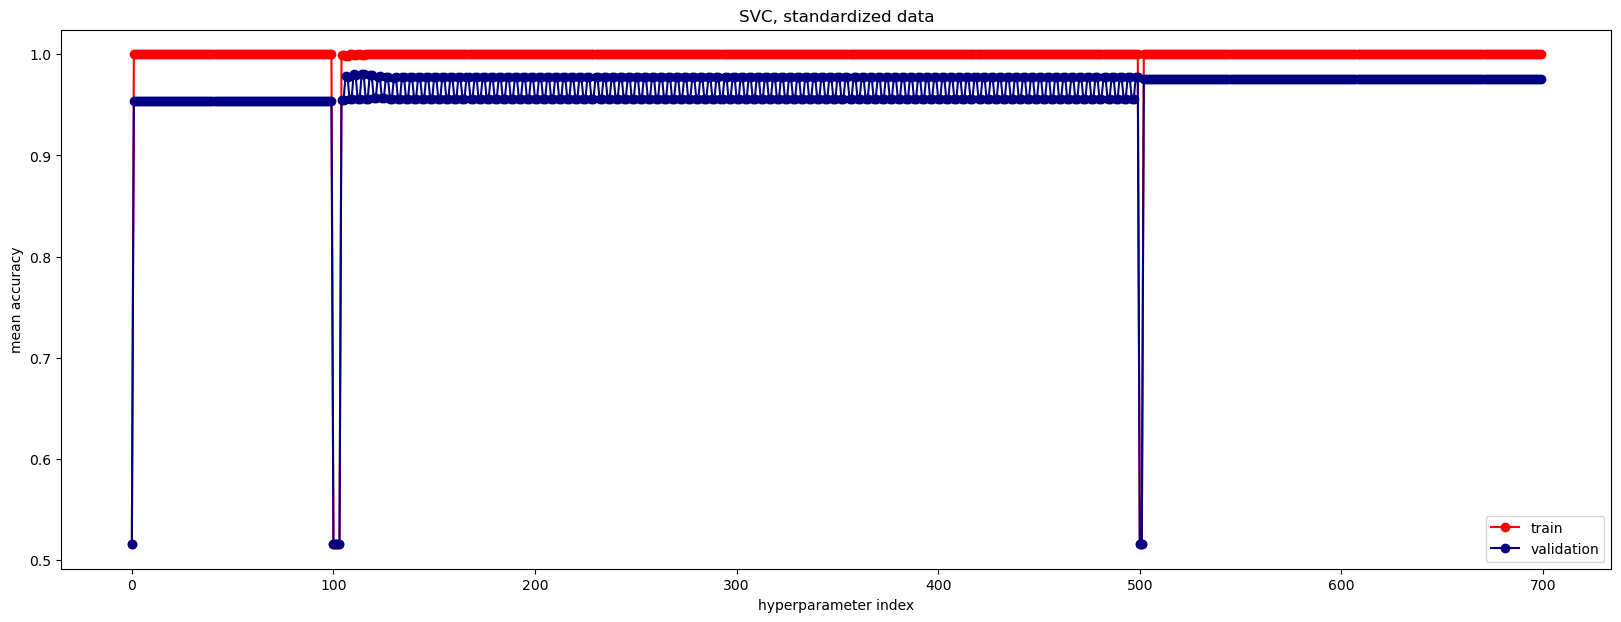

In [75]:
evaluate(grid_search, title="SVC, standardized data")

In [72]:
gamma_scale = 1 / (X_train.shape[0] * X_train.var().mean())
print(gamma_scale)
gamma_auto = 1 / X_train.shape[0]
print(gamma_auto)
# gamma = np.concatenate((np.linspace(1e-08, 1e-4, num=10)))
gamma = ['scale', 'auto']

2.4083958302829323e-07
0.0006944444444444445


## Naive Bayes

In [87]:
param_grid = {'alpha': np.linspace(start=0.1, stop=10, num=10),
              'binarize': np.linspace(start=0, stop=255, num=10)}
model = BernoulliNB()

In [88]:
grid_search = train(X_cross_val, y_cross_val, model, param_grid,
                    file_name=f"train_results/naive_bayes/original_rd-{random_seed}.pickle")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 2/100] START alpha=0.1, binarize=28.333333333333332....................
[CV 1/5; 2/100] END alpha=0.1, binarize=28.333333333333332;, score=(train=0.950, test=0.948) total time=   0.1s
[CV 2/5; 3/100] START alpha=0.1, binarize=56.666666666666664....................
[CV 2/5; 3/100] END alpha=0.1, binarize=56.666666666666664;, score=(train=0.950, test=0.940) total time=   0.1s
[CV 5/5; 3/100] START alpha=0.1, binarize=56.666666666666664....................
[CV 5/5; 3/100] END alpha=0.1, binarize=56.666666666666664;, score=(train=0.946, test=0.950) total time=   0.1s
[CV 1/5; 5/100] START alpha=0.1, binarize=113.33333333333333....................
[CV 1/5; 5/100] END alpha=0.1, binarize=113.33333333333333;, score=(train=0.931, test=0.940) total time=   0.1s
[CV 3/5; 6/100] START alpha=0.1, binarize=141.66666666666666....................
[CV 3/5; 6/100] END alpha=0.1, binarize=141.66666666666666;, score=(train=0.924, tes

Best parameters: {'alpha': 0.1, 'binarize': 28.333333333333332}
Best cross-validation score: 0.9483333333333333


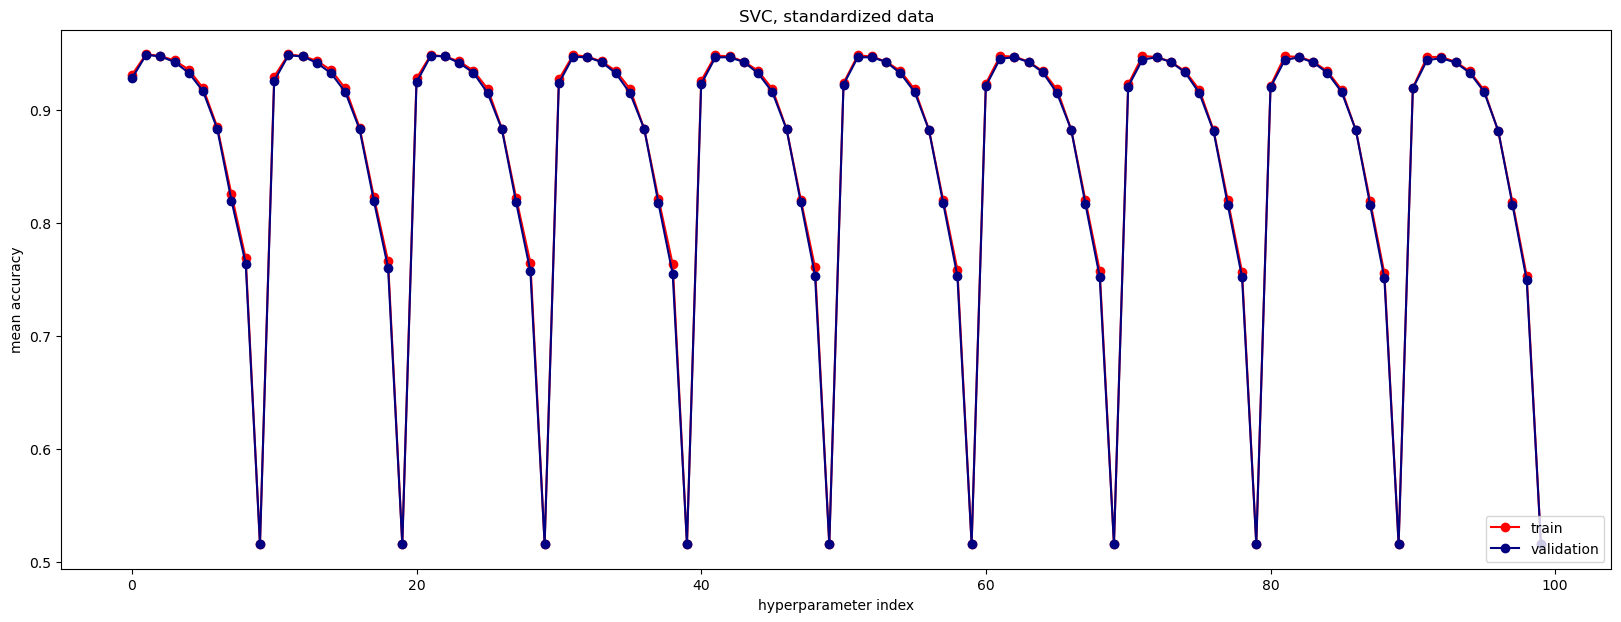

In [89]:
evaluate(grid_search, title="Bernoulli Naive Bayes, original data")

### Normalization

In [91]:
param_grid = {'alpha': np.linspace(start=0.1, stop=10, num=10),
              'binarize': np.linspace(start=0, stop=1, num=10)}

grid_search = train(X_cross_val_normalized, y_cross_val, model, param_grid,
                    file_name=f"train_results/naive_bayes/normalized_rd-{random_seed}.pickle")

Could not open file train_results/naive_bayes/normalized_rd-42.pickle (file not found error), proceeding with training.
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 5/5; 74/100] END alpha=7.800000000000001, binarize=85.0;, score=(train=0.940, test=0.946) total time=   0.1s
[CV 5/5; 76/100] START alpha=7.800000000000001, binarize=141.66666666666666.....
[CV 5/5; 76/100] END alpha=7.800000000000001, binarize=141.66666666666666;, score=(train=0.918, test=0.917) total time=   0.1s
[CV 4/5; 78/100] START alpha=7.800000000000001, binarize=198.33333333333331.....
[CV 4/5; 78/100] END alpha=7.800000000000001, binarize=198.33333333333331;, score=(train=0.818, test=0.823) total time=   0.1s
[CV 5/5; 80/100] START alpha=7.800000000000001, binarize=255.0..................
[CV 5/5; 80/100] END alpha=7.800000000000001, binarize=255.0;, score=(train=0.516, test=0.517) total time=   0.1s
[CV 2/5; 83/100] START alpha=8.9, binarize=56.666666666666664...................
[CV 2/5; 83/

Best parameters: {'alpha': 0.1, 'binarize': 0.1111111111111111}
Best cross-validation score: 0.9479166666666666


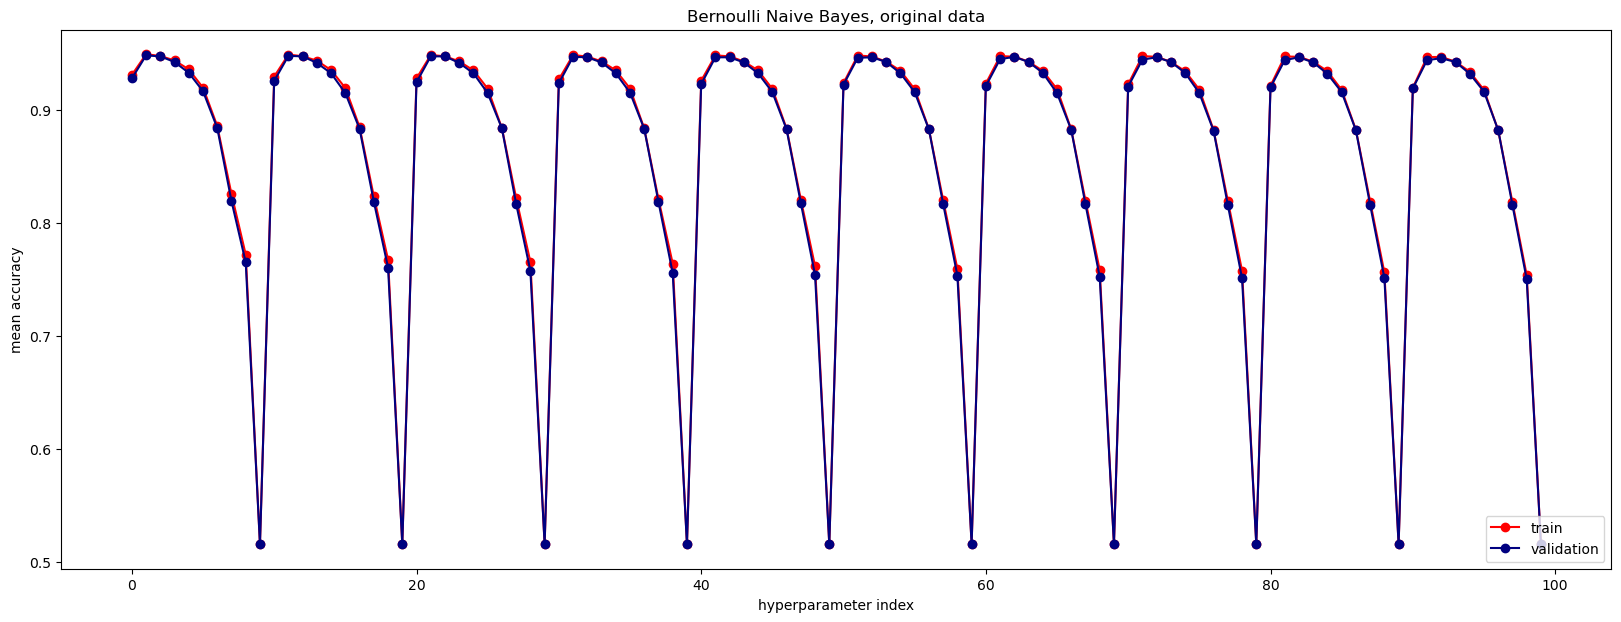

In [92]:
evaluate(grid_search, title="Bernoulli Naive Bayes, original data")

### Standardization

impossible

## MultinomialNB

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 5/5; 1/10] START alpha=0.1..................................................
[CV 5/5; 1/10] END alpha=0.1;, score=(train=0.938, test=0.929) total time=   0.0s
[CV 1/5; 4/10] START alpha=3.4000000000000004...................................
[CV 1/5; 4/10] END alpha=3.4000000000000004;, score=(train=0.936, test=0.948) total time=   0.0s
[CV 3/5; 5/10] START alpha=4.5..................................................
[CV 3/5; 5/10] END alpha=4.5;, score=(train=0.938, test=0.927) total time=   0.0s
[CV 2/5; 7/10] START alpha=6.7..................................................
[CV 2/5; 7/10] END alpha=6.7;, score=(train=0.939, test=0.931) total time=   0.0s
[CV 4/5; 8/10] START alpha=7.800000000000001....................................
[CV 4/5; 8/10] END alpha=7.800000000000001;, score=(train=0.933, test=0.946) total time=   0.1s
[CV 3/5; 1/100] START alpha=0.1.................................................
[CV 3/5; 1/1

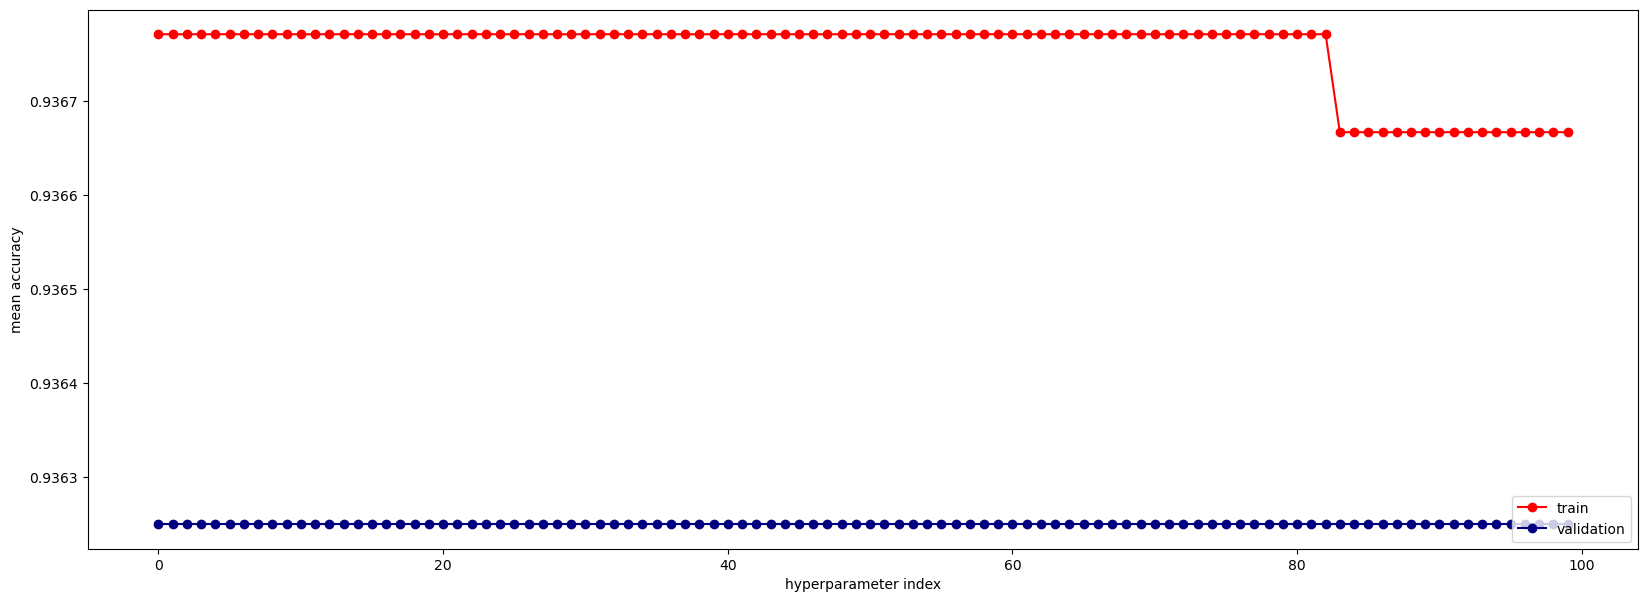

In [100]:

param_grid = {"alpha": np.linspace(start=0.1, stop=10, num=100)}

model = MultinomialNB()

grid_search = train(X_cross_val, y_cross_val, model, param_grid,
                    file_name=f"train_results/naive_bayes/multinomial_original_rd-{random_seed}.pickle")
evaluate(grid_search, title="")

## CategoricalNB 

## GaussianNB

## LDA

Could not open file train_results/lda/original_rd-42.pickle (file not found error), proceeding with training.
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/home/bardanik/miniforge3/envs/bi-ml/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/bardanik/miniforge3/envs/bi-ml/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/bardanik/miniforge3/envs/bi-ml/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bardanik/miniforge3/envs/bi-ml/lib/pyt

Best parameters: {'solver': 'svd'}
Best cross-validation score: 0.9291666666666666


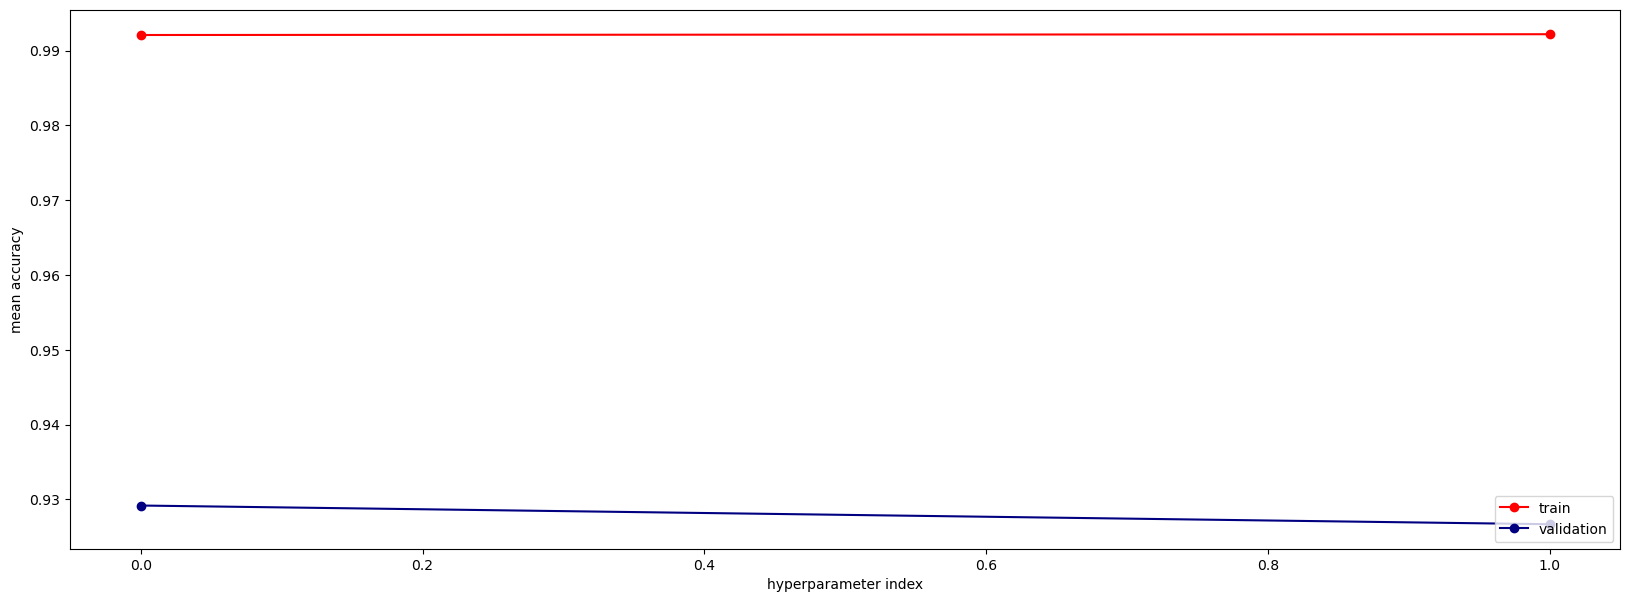

In [106]:
param_grid = {'solver': ['svd', 'lsqr', 'eigen']}
model = LinearDiscriminantAnalysis()
grid_search = train(X_cross_val, y_cross_val, model, param_grid, file_name=f"train_results/lda/original_rd-{random_seed}.pickle")
evaluate(grid_search, "")

### Normalization

Could not open file train_results/lda/normalized_rd-42.pickle (file not found error), proceeding with training.
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/home/bardanik/miniforge3/envs/bi-ml/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/bardanik/miniforge3/envs/bi-ml/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/bardanik/miniforge3/envs/bi-ml/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bardanik/miniforge3/envs/bi-ml/lib/pyt

Best parameters: {'solver': 'svd'}
Best cross-validation score: 0.9291666666666666


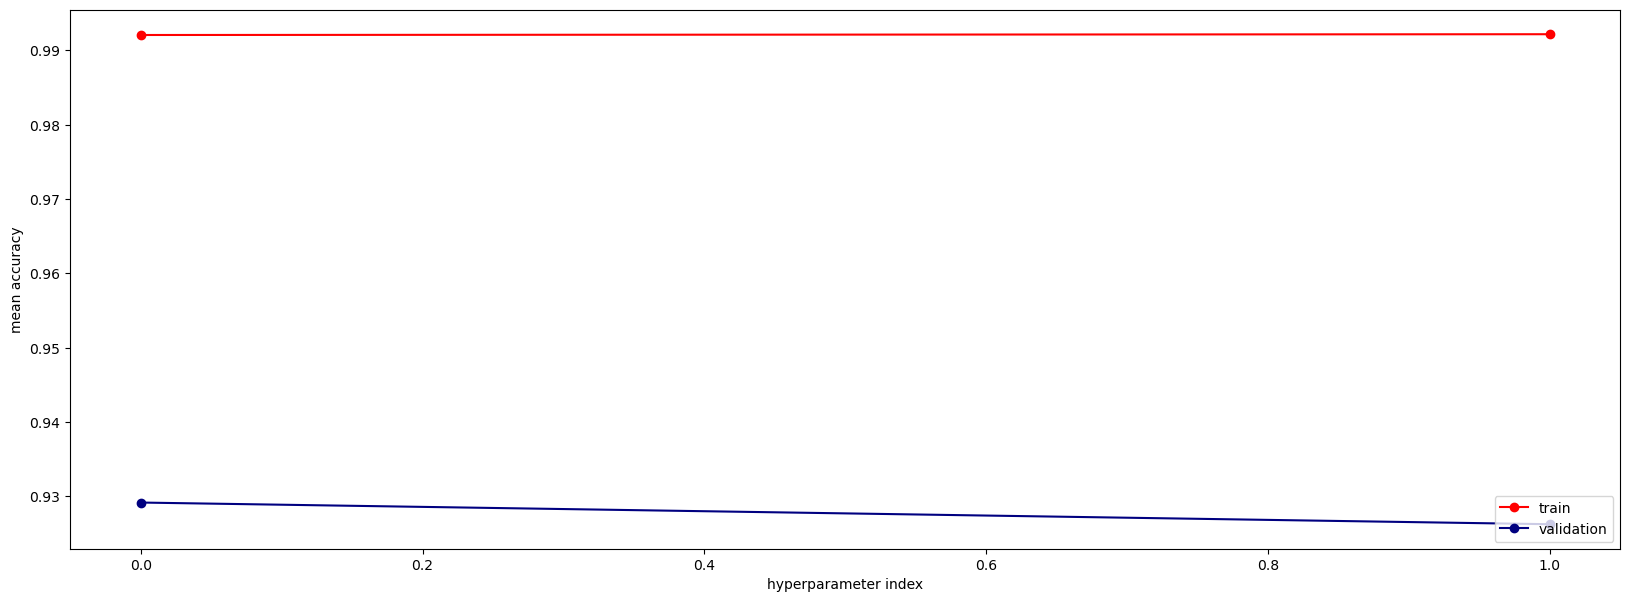

In [107]:
grid_search = train(X_cross_val_normalized, y_cross_val, model, param_grid, file_name=f"train_results/lda/normalized_rd-{random_seed}.pickle")
evaluate(grid_search, "")

Could not open file train_results/lda/standardized_rd-42.pickle (file not found error), proceeding with training.
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/home/bardanik/miniforge3/envs/bi-ml/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/bardanik/miniforge3/envs/bi-ml/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/bardanik/miniforge3/envs/bi-ml/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bardanik/miniforge3/envs/bi-ml/lib/pyt

Best parameters: {'solver': 'lsqr'}
Best cross-validation score: 0.9254166666666667


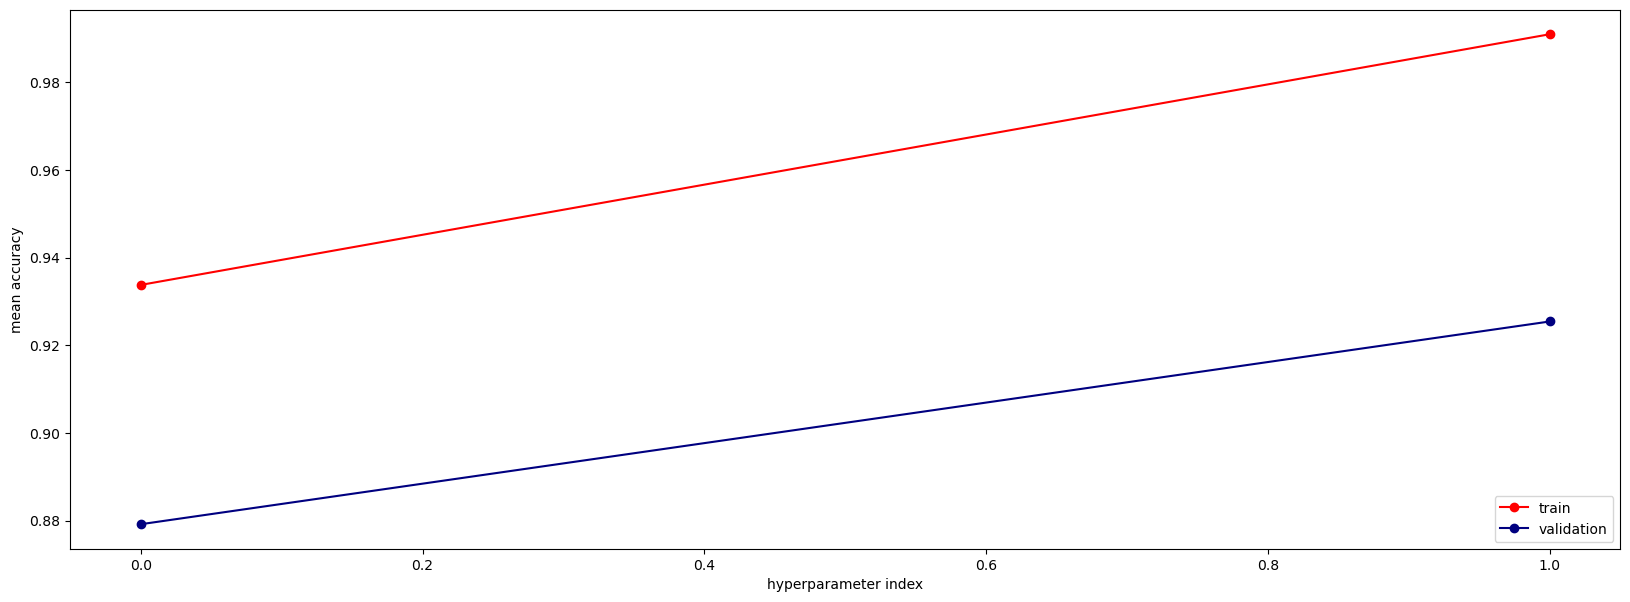

In [108]:
grid_search = train(X_cross_val_standardized, y_cross_val, model, param_grid, file_name=f"train_results/lda/standardized_rd-{random_seed}.pickle")
evaluate(grid_search, "")

# PCA

# LLE